# Visualization for Delegation Based Lock

In [2]:
using DataFrames, CSV

bench = CSV.read("output/output.csv", DataFrame)


Row,Id,CpuId,LoopCount,NumAcquire,HoldTime,Locktype
,Int64,Int64,Int64,Int64,Int64,String31
1,0,0,21917691,39945,411,Flat Combining Fair
2,1,1,21913287,13289,414,Flat Combining Fair
3,2,2,20788709,37875,410,Flat Combining Fair
4,3,3,21780988,13219,415,Flat Combining Fair
5,0,0,12958425,23395,273,Flat Combining
6,1,1,37096115,22349,679,Flat Combining
7,2,2,12745678,22754,261,Flat Combining
8,3,3,34423032,20760,631,Flat Combining
9,0,0,1447139,3016,32,Mutex


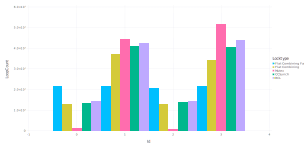

In [9]:
using Gadfly

p = plot(bench)

push!(p, layer(x=:Id, y=:LoopCount, color=:Locktype, Geom.bar(position=:dodge)))

draw(SVG(12inch, 6inch), p)

In [19]:
bench

Row,Id,CpuId,LoopCount,NumAcquire,HoldTime,Locktype
,Int64,Int64,Int64,Int64,Int64,String31
1,0,0,21917691,39945,411,Flat Combining Fair
2,1,1,21913287,13289,414,Flat Combining Fair
3,2,2,20788709,37875,410,Flat Combining Fair
4,3,3,21780988,13219,415,Flat Combining Fair
5,0,0,12958425,23395,273,Flat Combining
6,1,1,37096115,22349,679,Flat Combining
7,2,2,12745678,22754,261,Flat Combining
8,3,3,34423032,20760,631,Flat Combining
9,0,0,1447139,3016,32,Mutex


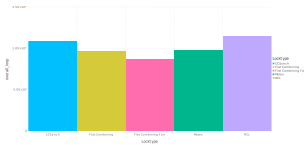

In [32]:
using Tidier

bench_all = @chain bench begin
    @group_by(Locktype)
    @summarize(overall_loop = sum(LoopCount))
end


p = plot(bench_all)
push!(p, layer(x=:Locktype, y=:overall_loop, Geom.bar, color=:Locktype))
draw(SVG(12inch, 6inch), p)